# How to manage state in subgraphs

For more complex systems, sub-graphs are a useful design principle. Sub-graphs allow you to create and manage different states in different parts of your graph. This allows you build things like [multi-agent teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/), where each team can track its own separate state.

In this how-to guide we will cover how to manage the persisted state in subgraphs. This will enable a lot of the human-in-the-loop interaction patterns.

In [3]:
%%capture --no-stderr
%pip install -U langgraph

## Setup SubGraph

First, let's set up our subgraph. For this, we will create a simple graph that can get the weather for a specific city.

In [1]:
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"I'ts sunny in {city}!"

raw_model = ChatOpenAI()
model = raw_model.with_structured_output(get_weather)


class SubGraphState(MessagesState):
    city: str


def model_node(state: SubGraphState):
    result = model.invoke(state['messages'])
    return {"city": result["city"]}

def weather_node(state: SubGraphState):
    result = get_weather.invoke({"city": state['city']})
    return {"messages": [{"role": "assistant", "content": result}]}


subgraph = StateGraph(SubGraphState)
subgraph.add_node(model_node)
subgraph.add_node(weather_node)
subgraph.add_edge(START, "model_node")
subgraph.add_edge("model_node", "weather_node")
subgraph.add_edge("weather_node", END)
subgraph = subgraph.compile(interrupt_before=["weather_node"])

## Setup Graph

We can now setup the overall graph. This graph will first route to the subgraph if it needs to get the weather, otherwise it will route to a normal LLM.

In [2]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]

router_model = raw_model.with_structured_output(Router)
    
def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state['messages']
    route = router_model.invoke(messages)
    return {"route": route['route']}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state['messages'])
    return {"messages": [response]}


def route_after_prediction(state: RouterState):
    if state['route'] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile(checkpointer=memory)

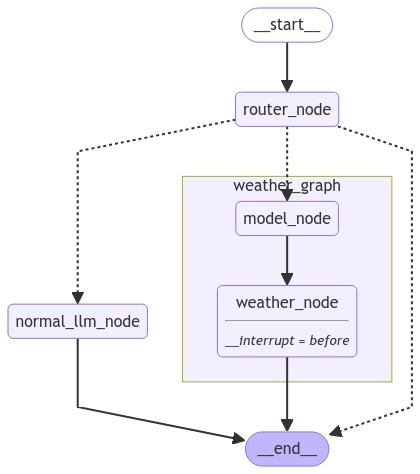

In [3]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's test this out with a normal query!

In [4]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "hi!"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'other'}}
{'normal_llm_node': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-a29f5f9a-6c18-42fb-ba42-24fd099b8841-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})]}}


## Resuming from breakpoints

Let's now look at what happens with breakpoints. Let's invoke it with a query that should get routed to the weather subgraph where we have the interrupt node.

In [5]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}


Note that this doesn't include subgraph events. If I want to stream subgraph events, I can pass `subgraphs=True` and get back subgraph events.

In [6]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="values", subgraphs=True):
    print(update)

((), {'messages': [HumanMessage(content="what's the weather in sf", id='75c7ba82-33db-421c-86a9-3cbc2f2d4740'), HumanMessage(content="what's the weather in sf", id='f9ad148e-350b-412a-8075-8eae75cd6142')], 'route': 'weather'})
((), {'messages': [HumanMessage(content="what's the weather in sf", id='75c7ba82-33db-421c-86a9-3cbc2f2d4740'), HumanMessage(content="what's the weather in sf", id='f9ad148e-350b-412a-8075-8eae75cd6142')], 'route': 'weather'})
(('weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e',), {'messages': [HumanMessage(content="what's the weather in sf", id='75c7ba82-33db-421c-86a9-3cbc2f2d4740'), HumanMessage(content="what's the weather in sf", id='f9ad148e-350b-412a-8075-8eae75cd6142')]})
(('weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e',), {'messages': [HumanMessage(content="what's the weather in sf", id='75c7ba82-33db-421c-86a9-3cbc2f2d4740'), HumanMessage(content="what's the weather in sf", id='f9ad148e-350b-412a-8075-8eae75cd6142')], 'city': 'San Francisco'})


If we get the state now, we can see that it's paused on `weather_graph`

In [7]:
state = graph.get_state(config)
state.next

('weather_graph',)

If we look at the tasks, we can see that we have one task and it has a state associate with it. That means the next execution is a subgraph and has some state

In [8]:
state.tasks[0]

PregelTask(id='37c544e7-84b4-5096-b5f5-f5bcd4def17e', name='weather_graph', error=None, interrupts=(), state={'configurable': {'thread_id': '2', 'checkpoint_ns': 'weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e'}})

We can get that state information by taking `state.tasks[0].state` and passing it back into `graph.get_state`. This will now return the state for that checkpoint, which corresponds to the subgraph state. This has all the information - like the next node (`weather_node`) and the current state

In [9]:
state = graph.get_state(state.tasks[0].state)
state

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='75c7ba82-33db-421c-86a9-3cbc2f2d4740'), HumanMessage(content="what's the weather in sf", id='f9ad148e-350b-412a-8075-8eae75cd6142')], 'city': 'San Francisco'}, next=('weather_node',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': 'weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e', 'checkpoint_id': '1ef66f39-4f52-6b5e-8001-b59212377a65', 'checkpoint_map': {'': '1ef66f39-4b32-6498-8004-70f81026b7b6', 'weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e': '1ef66f39-4f52-6b5e-8001-b59212377a65'}}}, metadata={'source': 'loop', 'writes': {'model_node': {'city': 'San Francisco'}}, 'step': 1, 'parents': {'': '1ef66f39-4b32-6498-8004-70f81026b7b6'}}, created_at='2024-08-30T17:16:23.395595+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': 'weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e', 'checkpoint_id': '1ef66f39-4b52-6180-8000-4a8e8acb73bf'}}, tasks=(PregelTask(id

Another way we can see that state by calling `graph.get_state` again but passing in `subgraphs=True` to show subgraph information. If we then look at the tasks, we can see a lot more information! This has all the information - like the next node (`weather_node`) and the current state

In [10]:
state = graph.get_state(config, subgraphs=True)
state.tasks[0]

PregelTask(id='37c544e7-84b4-5096-b5f5-f5bcd4def17e', name='weather_graph', error=None, interrupts=(), state=StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='75c7ba82-33db-421c-86a9-3cbc2f2d4740'), HumanMessage(content="what's the weather in sf", id='f9ad148e-350b-412a-8075-8eae75cd6142')], 'city': 'San Francisco'}, next=('weather_node',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': 'weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e', 'checkpoint_id': '1ef66f39-4f52-6b5e-8001-b59212377a65', 'checkpoint_map': {'': '1ef66f39-4b32-6498-8004-70f81026b7b6', 'weather_graph:37c544e7-84b4-5096-b5f5-f5bcd4def17e': '1ef66f39-4f52-6b5e-8001-b59212377a65'}}}, metadata={'source': 'loop', 'writes': {'model_node': {'city': 'San Francisco'}}, 'step': 1, 'parents': {'': '1ef66f39-4b32-6498-8004-70f81026b7b6'}}, created_at='2024-08-30T17:16:23.395595+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': 'weather_graph:37c544e7-

To resume execution, we can just invoke the outer graph as normal

In [11]:
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)

{'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='75c7ba82-33db-421c-86a9-3cbc2f2d4740'), HumanMessage(content="what's the weather in sf", id='f9ad148e-350b-412a-8075-8eae75cd6142'), AIMessage(content="I'ts sunny in San Francisco!", id='45055c39-d13c-4a82-9bd5-c273e693374c')]}}


## Modifying state

What if we want to modify the state? We can do this by updating the state at the point in time.

In [12]:
config = {"configurable": {"thread_id": "4"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}


In [13]:
state = graph.get_state(config, subgraphs=True)
state.values['messages']

[HumanMessage(content="what's the weather in sf", id='d9384957-ac31-4abd-a1f0-70e3dcb9c30e')]

In order to update the state of the **inner** graph, we need to pass the config for that graph

In [14]:
graph.update_state(state.tasks[0].state.config, {"city": "la"})

{'configurable': {'thread_id': '4',
  'checkpoint_ns': 'weather_graph:9f95ecac-08d7-5350-9b1f-970f6837f486',
  'checkpoint_id': '1ef66f3a-57a2-68c6-8002-d9d6ceeec784',
  'checkpoint_map': {'': '1ef66f3a-279b-6c04-8001-f80b83ea9538',
   'weather_graph:9f95ecac-08d7-5350-9b1f-970f6837f486': '1ef66f3a-57a2-68c6-8002-d9d6ceeec784'}}}

In [15]:
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)

(('weather_graph:9f95ecac-08d7-5350-9b1f-970f6837f486',), {'weather_node': {'messages': [{'role': 'assistant', 'content': "I'ts sunny in la!"}]}})
((), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='d9384957-ac31-4abd-a1f0-70e3dcb9c30e'), AIMessage(content="I'ts sunny in la!", id='0a09d270-a2d0-4e7c-aa33-f9c9ae0c29fa')]}})


If we want to, we we can also update the state by adding a message acting as the weather node in the subgraph. We can do this by passing the subgraph config and then also the `as_node` argument.

In [17]:
config = {"configurable": {"thread_id": "14"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates", subgraphs=True):
    print(update)
print("interrupted!")
state = graph.get_state(config, subgraphs=True)
graph.update_state(state.tasks[0].state.config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node="weather_node")
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)
print(graph.get_state(config).values['messages'])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:818eda98-159e-575a-bff8-072a8ab1b5cb',), {'model_node': {'city': 'San Francisco'}})
StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='ddf3f71c-31d7-45f9-b499-3d8d87657b58')], 'route': 'weather'}, next=('weather_graph',), config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f3d-ee1f-61b6-8001-f3b8dbb27202'}}, metadata={'source': 'loop', 'writes': {'router_node': {'route': 'weather'}}, 'step': 1, 'parents': {}}, created_at='2024-08-30T17:18:27.421004+00:00', parent_config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f3d-e8e0-6bc8-8000-0422169e5363'}}, tasks=(PregelTask(id='818eda98-159e-575a-bff8-072a8ab1b5cb', name='weather_graph', error=None, interrupts=(), state=StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='ddf3f71c-31d7-45f9-b499-3d8d87657b58'), AIMessage(content='rainy', id=

We could also update the graph just acting as the **entire** subgraph. This is done with the normal config as well as the `as_node` argument

In [18]:
config = {"configurable": {"thread_id": "8"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates", subgraphs=True):
    print(update)
print("interrupted!")
graph.update_state(config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node="weather_graph")
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)
print(graph.get_state(config).values['messages'])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:e979ba61-4004-5257-b8d6-94f5b045027a',), {'model_node': {'city': 'San Francisco'}})
interrupted!
[HumanMessage(content="what's the weather in sf", id='414e0e76-66f0-40ed-a3b7-93d67436eb85'), AIMessage(content='rainy', id='0d1e4415-f7c0-4832-8898-761ac263cc1b')]


## Triple nested subgraphs

This same functionality continues to work no matter the level of nesting. Here is an example of doing the same things with a triple nested subgraph. We add another router on top of our already defined graphs.

In [19]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]

router_model = raw_model.with_structured_output(Router)
    
def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state['messages']
    route = router_model.invoke(messages)
    return {"route": route['route']}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state['messages'])
    return {"messages": [response]}


def route_after_prediction(state: RouterState):
    if state['route'] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile()

In [20]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class GrandfatherState(MessagesState):
    to_continue: bool

    
def router_node(state: GrandfatherState):
    # Dummy logic that will always continue
    return {"to_continue": True}



def route_after_prediction(state: GrandfatherState):
    if state['to_continue']:
        return "graph"
    else:
        return END


grandfather_graph = StateGraph(GrandfatherState)
grandfather_graph.add_node(router_node)
grandfather_graph.add_node("graph", graph)
grandfather_graph.add_edge(START, "router_node")
grandfather_graph.add_conditional_edges("router_node", route_after_prediction)
grandfather_graph.add_edge("graph", END)
grandfather_graph = grandfather_graph.compile(checkpointer=MemorySaver())

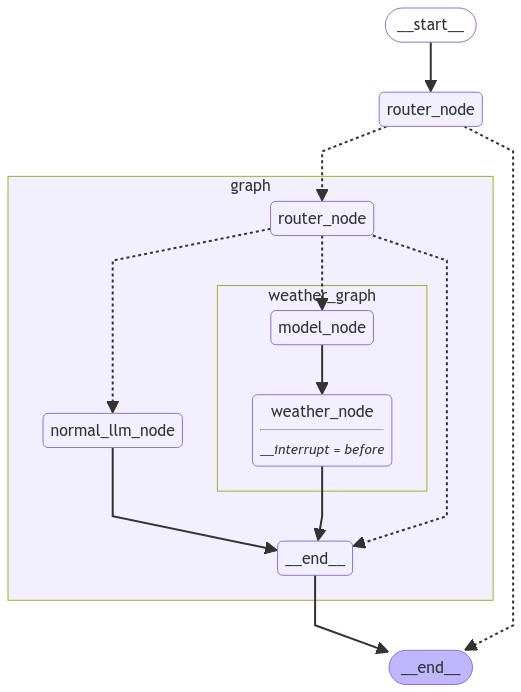

In [21]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(grandfather_graph.get_graph(xray=2).draw_mermaid_png()))

If we run until the interrupt, we can now see that there are snapshots of the state of all three graphs

In [22]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in grandfather_graph.stream(inputs, config=config, stream_mode="updates", subgraphs=True):
    print(update)

((), {'router_node': {'to_continue': True}})
(('graph:b59fe96f-fdce-5afe-aa58-bd2876a0d592',), {'router_node': {'route': 'weather'}})
(('graph:b59fe96f-fdce-5afe-aa58-bd2876a0d592', 'weather_graph:9b4829e9-dd5d-5344-a2fc-2631e55eba8e'), {'model_node': {'city': 'San Francisco'}})


In [23]:
state = grandfather_graph.get_state(config, subgraphs=True)
print("GrandFather State:")
print(state.values)
print("---------------")
print("Graph State:")
print(state.tasks[0].state.values)
print("---------------")
print("SubGraph State:")
print(state.tasks[0].state.tasks[0].state.values)

GrandFather State:
{'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720')], 'to_continue': True}
---------------
Graph State:
{'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720')], 'route': 'weather'}
---------------
SubGraph State:
{'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720')], 'city': 'San Francisco'}


We can now continue, acting as the node three levels down

In [24]:
bottom_config = state.tasks[0].state.tasks[0].state.config
grandfather_graph.update_state(bottom_config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node="weather_node")
for update in grandfather_graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)
print(grandfather_graph.get_state(config).values['messages'])

(('graph:b59fe96f-fdce-5afe-aa58-bd2876a0d592',), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720'), AIMessage(content='rainy', id='7c80f847-248d-4b8f-8238-633ed757b353')]}})
((), {'graph': {'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720'), AIMessage(content='rainy', id='7c80f847-248d-4b8f-8238-633ed757b353')]}})
[HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720'), AIMessage(content='rainy', id='7c80f847-248d-4b8f-8238-633ed757b353')]


In [25]:
for state in grandfather_graph.get_state_history(config):
    print(state)
    print("-----")

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720'), AIMessage(content='rainy', id='7c80f847-248d-4b8f-8238-633ed757b353')], 'to_continue': True}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f40-7a2c-6f9e-8002-a37a61b26709'}}, metadata={'source': 'loop', 'writes': {'graph': {'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720'), AIMessage(content='rainy', id='7c80f847-248d-4b8f-8238-633ed757b353')]}}, 'step': 2, 'parents': {}}, created_at='2024-08-30T17:19:35.793847+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f3f-f312-6338-8001-766acddc781e'}}, tasks=())
-----
StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='5ff89e4d-8255-4d23-8b55-01633c112720')], 'to_continue': True}, next=('graph',), config={'configurable': {'thr

In [42]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langchain_anthropic import ChatAnthropic

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


model = ChatAnthropic(model="claude-3-5-sonnet-20240620")

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str
    jokes: Annotated[list, operator.add]


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

joke_graph = StateGraph(JokeState)
joke_graph.add_node(generate_joke)
joke_graph.add_edge(START, "generate_joke")
joke_graph.add_edge("generate_joke", END)
joke_graph = joke_graph.compile()


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", joke_graph)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

In [43]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Lion', 'Elephant', 'Penguin', 'Giraffe']}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? Because they're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ["Why don't lions like fast food? Because they can't catch it!"]}}
{'generate_joke': {'jokes': ["Why don't penguins like online shopping? They're afraid of the ice-cart!"]}}
{'generate_joke': {'jokes': ["Why don't giraffes ever gossip? Because they can't keep anything under their necks!"]}}
{'best_joke': {'best_selected_joke': "Why don't penguins like online shopping? They're afraid of the ice-cart!"}}


In [34]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int = Field(..., description="Index, starting with 0")


model = ChatAnthropic(model="claude-3-5-sonnet-20240620")

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str
    jokes: Annotated[list, operator.add]


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

def edit_subject(state: JokeState):
    return {"subject": "pink " + state["subject"]}

joke_graph = StateGraph(JokeState)
joke_graph.add_node("generate_joke", generate_joke)
joke_graph.add_node("edit_subject", edit_subject)
joke_graph.add_edge(START, "edit_subject")
joke_graph.add_edge("edit_subject", "generate_joke")
joke_graph.add_edge("generate_joke", END)
joke_graph = joke_graph.compile(interrupt_before=["generate_joke"])


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", joke_graph)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

In [35]:
config = {"configurable": {"thread_id": "1"}}
res = app.invoke({"topic": "animals"}, config)
state = app.get_state(config, subgraphs=True)

In [40]:
res = app.invoke(None, config)

In [41]:
res

{'topic': 'animals',
 'subjects': ['lion', 'elephant', 'penguin', 'giraffe'],
 'jokes': ['Why was the pink lion so embarrassed? Because he was caught lion about his natural color!',
  "Why don't you ever see elephants hiding in trees? Because they're really good at it, especially the pink ones!",
  'Why did the pink penguin get kicked out of the zoo? Because it was caught salmon-dancing!',
  'Why did the pink giraffe always win at hide and seek? Because no one could spot it!'],
 'best_selected_joke': 'Why did the pink giraffe always win at hide and seek? Because no one could spot it!'}

In [32]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langchain_anthropic import ChatAnthropic

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


model = ChatAnthropic(model="claude-3-5-sonnet-20240620")

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer, interrupt_before=["generate_joke"])

In [33]:
config = {"configurable": {"thread_id": "1"}}
res = app.invoke({"topic": "animals"}, config)
app.get_state(config, subgraphs=True)

StateSnapshot(values={'topic': 'animals', 'subjects': ['lion', 'elephant', 'penguin', 'dolphin'], 'jokes': []}, next=('generate_joke', 'generate_joke', 'generate_joke', 'generate_joke'), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f47-4201-63fc-8001-de3ca28f48dc'}}, metadata={'source': 'loop', 'writes': {'generate_topics': {'subjects': ['lion', 'elephant', 'penguin', 'dolphin']}}, 'step': 1, 'parents': {}}, created_at='2024-08-30T17:22:37.808717+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef66f47-3636-60b8-8000-f3fefe9fcab7'}}, tasks=(PregelTask(id='2deec87f-7c8f-537f-b8b5-95f45d30edea', name='generate_joke', error=None, interrupts=(), state=None), PregelTask(id='12cfc7f5-93bd-5173-9bd8-073a1643d29d', name='generate_joke', error=None, interrupts=(), state=None), PregelTask(id='38993d07-3b8a-5c39-8a3d-70c3ff393eff', name='generate_joke', error=None, interrupts=(), state=None), PregelTask(id=

In [99]:
app.get_state(config).values

{'topic': 'animals',
 'subjects': ['lion', 'elephant', 'penguin', 'giraffe'],
 'jokes': []}